In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io as sio
import torch 

def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

_EPSILON_ = 1.0e-7
def map_one_range_to_other(input, output_start, output_end, input_start, input_end):
    " end is inclusive! "
    output = output_start + ((output_end - output_start) / (_EPSILON_ + input_end - input_start)) * (input - input_start)
    return output

0.9529556 0.9864729


(480, 480)

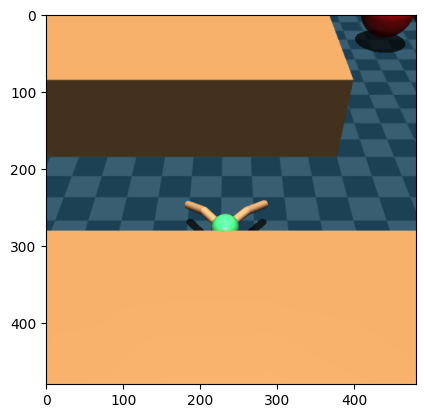

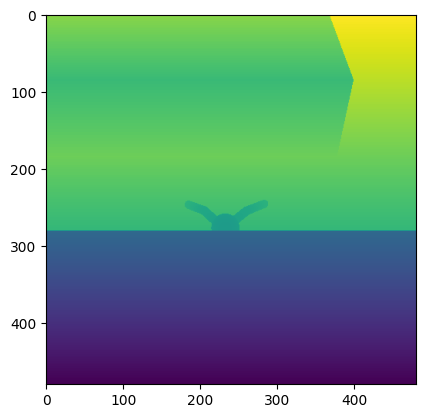

In [34]:
rgb = np.array(Image.open("../3d_debug/rgb_array_large_0.png"))
depth = np.array(np.load("../3d_debug/depth_array_0.npy"))
print(depth.min(), depth.max())
# depth = normalize(depth)

plt.figure(); plt.imshow(rgb)
plt.figure(); plt.imshow(depth)
depth.min(), depth.max()
depth.shape

In [3]:

def generate_defocus_phase(disc_depth_range, psf_kernel_size, wvls):
    """
    See Training/Implementaion details in https://drive.google.com/file/d/1ISWnM1NhrcNpu5vBtejTQdS9GNuiQyqW/view?pli=1 
    code: https://github.com/YichengWu/PhaseCam3D/blob/master/depth_estimation.py#L96
    disc_depth_range: 
    wvls: wavelength that psf is suceptible to. 
    """
    # return (Phi_list,pixel,pixel,color)
    x0 = np.linspace(-1.1, 1.1, psf_kernel_size)
    xx, yy = np.meshgrid(x0, x0)
    defocus_phase = np.empty([len(disc_depth_range), psf_kernel_size, psf_kernel_size, len(wvls)], dtype=np.float32)
    for j in range(len(disc_depth_range)):
        phi = disc_depth_range[j]
        for k in range(len(wvls)):
            defocus_phase[j, :, :, k] = phi * (xx ** 2 + yy ** 2) * wvls[1] / wvls[k];
    return defocus_phase

# this depends on the (near, far) from mujoco renderer. we will never have negative depths.. 
# Wm is negative for depths outside the focal plane, positive for between sensor & focal plane

disc_depth_range = np.linspace(-10, 10, 21, np.float32) 
psf_kernel_size = 23 # we should probably (10,10) to keep the parameters small. 
wvls=np.array([610., 530., 470.]) * 1e-9
defocus_phase = generate_defocus_phase(disc_depth_range, psf_kernel_size, wvls)

In [4]:
zernike = sio.loadmat('../3d_debug/zernike_basis.mat')
u2 = zernike['u2']  # basis of zernike poly
n_coeff_zernike = u2.shape[1]
idx = zernike['idx']
idx = idx.astype(np.float32)
idx.shape, u2.shape

((23, 23), (529, 55))

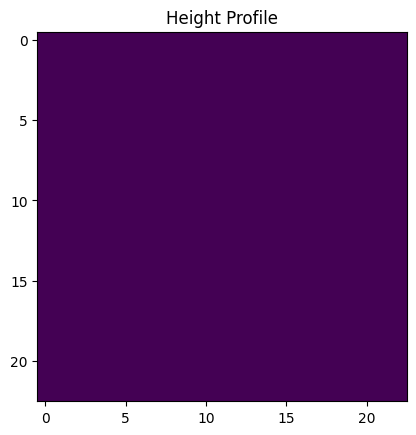

In [50]:
def get_height_map(alpha_zernike, n_coeff_zernike, u2, psf_kernel_size, wvls, init_func='random'):

    if alpha_zernike == None:
        alpha_zernike = torch.zeros((n_coeff_zernike, 1), dtype=torch.float32)

    clip_alphas = lambda x: torch.clip(x, -wvls[1] / 2, wvls[1] / 2)
    alpha_zernike = clip_alphas(alpha_zernike)
    g = torch.matmul(torch.tensor(u2), alpha_zernike)
    height_map = torch.relu(g.reshape((psf_kernel_size, psf_kernel_size)) + wvls[1])
    return height_map

# alpha_zernike = torch.rand((n_coeff_zernike, 1), dtype=torch.float32)
alpha_zernike = None
height_mask = get_height_map(alpha_zernike, n_coeff_zernike, u2, psf_kernel_size, wvls)
plt.figure(); plt.title("Height Profile"); plt.imshow(height_mask.numpy())

In [51]:
import pdb;
def fft2dshift(input):
    dim = input.shape[1]  # dimension of the data
    if dim % 2 == 0:
        raise ValueError('Please make the size of kernel odd')
    # pdb.set_trace()c
    
    channel1 = input.shape[0]  # channels for the first dimension
    # shift up and down
    # u = torch.slice(input, [0, 0, 0], [channel1, int((dim + 1) / 2), dim])
    u = input[0:channel1, 0:int((dim + 1) / 2), 0:dim]
    
    # d = torch.slice(input, [0, int((dim + 1) / 2), 0], [channel1, int((dim - 1) / 2), dim])
    d = input[0:channel1, int((dim + 1) / 2):int((dim + 1) / 2) + int((dim - 1) / 2), 0:dim]
    du = torch.concat([d, u], axis=1)
    
    # shift left and right
    # l = torch.slice(du, [0, 0, 0], [channel1, dim, int((dim + 1) / 2)])
    l = du[0:channel1, 0:dim, 0:int((dim + 1) / 2)]
    # r = torch.slice(du, [0, 0, int((dim + 1) / 2)], [channel1, dim, int((dim - 1) / 2)])
    r = du[0:channel1, 0:dim, int((dim + 1) / 2):int((dim + 1) / 2) + int((dim - 1) / 2)]
    output = torch.concat([r, l], axis=2)
    return output

def generate_psf_from_height_map(height_mask, defocus_phase, wvls, idx, N_R, N_G, N_B, refactive_idx=1.5):
    idx = torch.tensor(idx)
    height_mask = torch.tensor(height_mask)
    defocus_phase = torch.tensor(defocus_phase)
    
    defocus_phase_r = defocus_phase[:, :, :, 0]
    phase_R = torch.add(2 * np.pi / wvls[0] * (refactive_idx - 1) * height_mask, defocus_phase_r)
    e_defocused_r = torch.mul(torch.complex(idx, torch.tensor(0.0)), torch.exp(torch.complex(torch.tensor(0.0), phase_R)))

    pad_r = ((N_R - N_B) // 2, (N_R - N_B) // 2, (N_R - N_B) // 2, (N_R - N_B) // 2)
    pupil_r = torch.nn.functional.pad(e_defocused_r, pad_r)
    norm_r = N_R * N_R * torch.sum(idx ** 2)
    fft_pupil_r = torch.fft.fft2(pupil_r); 
    psf_r = torch.divide(torch.square(torch.abs(fft2dshift(fft_pupil_r))), norm_r)

    defocus_phase_g = defocus_phase[:, :, :, 1]
    phase_G = torch.add(2 * np.pi / wvls[1] * (refactive_idx - 1) * height_mask, defocus_phase_g)
    e_defocused_g = torch.mul(torch.complex(idx, torch.tensor(0.0)), torch.exp(torch.complex(torch.tensor(0.0), phase_G)))
    pad_g = ((N_G - N_B) // 2, (N_G - N_B) // 2, (N_G - N_B) // 2, (N_G - N_B) // 2)
    pupil_g = torch.nn.functional.pad(e_defocused_g, pad_g)
    norm_g = N_G * N_G * torch.sum(idx ** 2)
    fft_pupil_g = torch.fft.fft2(pupil_g)
    psf_g = torch.divide(torch.square(torch.abs(fft2dshift(fft_pupil_g))), norm_g)

    defocus_phase_b = defocus_phase[:, :, :, 2]
    phase_B = torch.add(2 * np.pi / wvls[2] * (refactive_idx - 1) * height_mask, defocus_phase_b)
    pupil_b = torch.mul(torch.complex(idx, torch.tensor(0.0)), torch.exp(torch.complex(torch.tensor(0.0), phase_B)))
    norm_b = N_B * N_B * torch.sum(idx ** 2)
    fft_pupil_b = torch.fft.fft2(pupil_b)
    psf_b = torch.divide(torch.square(torch.abs(fft2dshift(fft_pupil_b))), norm_b)
    print(psf_r.shape, psf_g.shape, psf_b.shape)

    N_crop_R = int((N_R - N_B) / 2)  # Num of pixel need to cropped at each side for R
    N_crop_G = int((N_G - N_B) / 2)  # Num of pixel need to cropped at each side for G

    psfs = torch.stack(
        [psf_r[:, N_crop_R:-N_crop_R, N_crop_R:-N_crop_R], psf_g[:, N_crop_G:-N_crop_G, N_crop_G:-N_crop_G], psf_b], axis=3)
            
    return psfs

N_R = 31
N_G = 27
N_B = 23  # size of the blur kernel

psfs = generate_psf_from_height_map(height_mask, defocus_phase, wvls, idx, N_R, N_G, N_B)
print(psfs.shape)

torch.Size([21, 31, 31]) torch.Size([21, 27, 27]) torch.Size([21, 23, 23])
torch.Size([21, 23, 23, 3])


/var/folders/x0/y71hkc8n5hg7cfbl_26b7jym0000gn/T/ipykernel_66914/3204578511.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  height_mask = torch.tensor(height_mask)


In [52]:
def blurImage(RGBPhi, DPPhi, PSFs):
    N_B = PSFs.shape[1]
    N_crop = np.int32((N_B - 1) / 2)
    N_Phi = PSFs.shape[0]

    sharp_R = RGBPhi[:, :, :, 0:1].permute(0,3,1,2)
    PSFs_R = torch.reshape(torch.permute(PSFs[:, :, :, 0], dims=(1, 2, 0)), [N_Phi, 1, N_B, N_B])
    blurAll_R = torch.nn.functional.conv2d(sharp_R, PSFs_R, stride=[1, 1], padding='valid')
    blur_R = torch.sum(torch.multiply(blurAll_R, DPPhi[:, :, N_crop:-N_crop, N_crop:-N_crop]), axis=1)
    
    sharp_G = RGBPhi[:, :, :, 1:2].permute(0,3,1,2)
    PSFs_G = torch.reshape(torch.permute(PSFs[:, :, :, 1], dims=[1, 2, 0]), [N_Phi, 1, N_B, N_B])
    blurAll_G = torch.nn.functional.conv2d(sharp_G, PSFs_G, stride=[1, 1], padding='valid')
    blur_G = torch.sum(torch.multiply(blurAll_G, DPPhi[:, :, N_crop:-N_crop, N_crop:-N_crop]), axis=1)


    sharp_B = RGBPhi[:, :, :, 2:3].permute(0,3,1,2)
    PSFs_B = torch.reshape(torch.permute(PSFs[:, :, :, 2], dims=[1, 2, 0]), [N_Phi, 1, N_B, N_B])
    blurAll_B = torch.nn.functional.conv2d(sharp_B, PSFs_B, stride=[1, 1], padding='valid')
    blur_B = torch.sum(torch.multiply(blurAll_B, DPPhi[:, :, N_crop:-N_crop, N_crop:-N_crop]), axis=1)

    blur = torch.stack([blur_R, blur_G, blur_B], axis=3).squeeze().numpy()
    # blur = np.clip(blur, 0., 1.)
    blur = normalize(blur) 
    return blur

def compute_disc_depths(mj_depth, min_bin, max_bin):
    disc_depth = []
    mj_depth = mj_depth.round().astype(np.uint8)
    for i in range(min_bin, max_bin+1, 1):
        idx = np.where(mj_depth == i)
        disc_depth_i = np.zeros_like(mj_depth ,dtype=np.float32)
        disc_depth_i[idx] = 1
        disc_depth.append(torch.tensor(disc_depth_i).unsqueeze(-1))

    disc_depth = torch.concat(disc_depth, -1)
    return disc_depth

rgb_torch = torch.tensor(rgb).unsqueeze(0)/255.
mj_depth = map_one_range_to_other(depth, 0, 1, depth.min(), depth.max()).round()
mj_depth = depth.round()
depth_torch = compute_disc_depths(mj_depth, -10, 10).unsqueeze(0).permute(0,3,1,2)
img = blurImage(rgb_torch, depth_torch, psfs)
print(img.shape)

(458, 458, 3)


Text(0.5, 1.0, 'RGB after PSF based Convolution ')

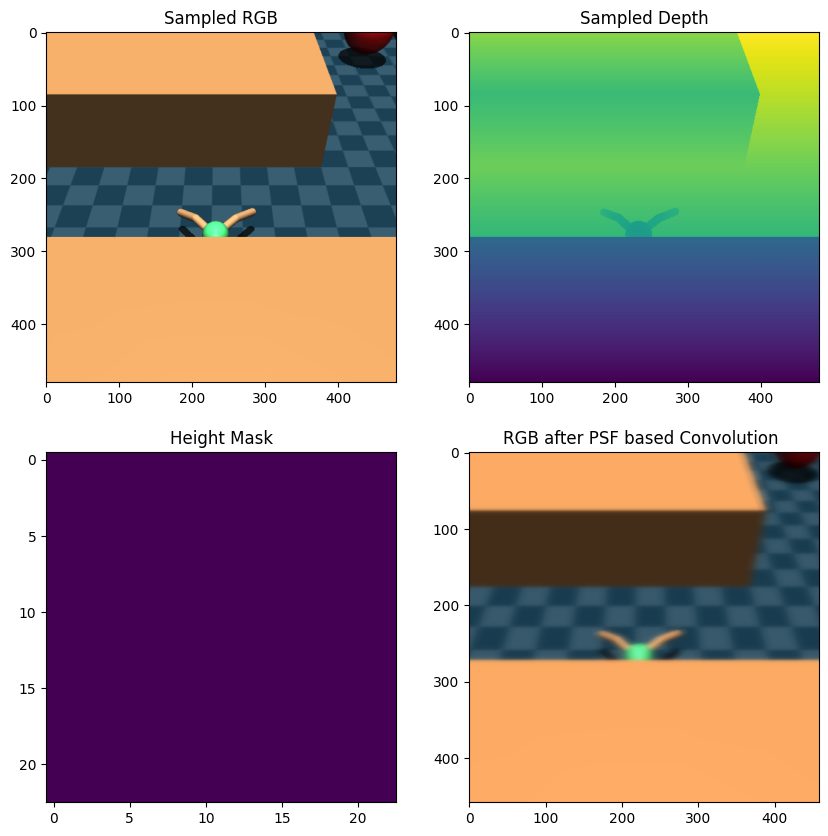

In [53]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rgb)
ax1.set_title("Sampled RGB")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(depth)
ax2.set_title("Sampled Depth")
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(height_mask)
ax3.set_title("Height Mask")
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img)
ax4.set_title("RGB after PSF based Convolution ")


In [59]:
# start from scratch here
height_mask_fisher = np.loadtxt('./FisherMask_HeightMap.txt').astype(np.float32)
fisher_psfs = generate_psf_from_height_map(height_mask_fisher, defocus_phase, wvls, idx, N_R, N_G, N_B)
img = blurImage(rgb_torch, depth_torch, fisher_psfs)


torch.Size([21, 31, 31]) torch.Size([21, 27, 27]) torch.Size([21, 23, 23])


Text(0.5, 1.0, 'RGB after PSF based Convolution ')

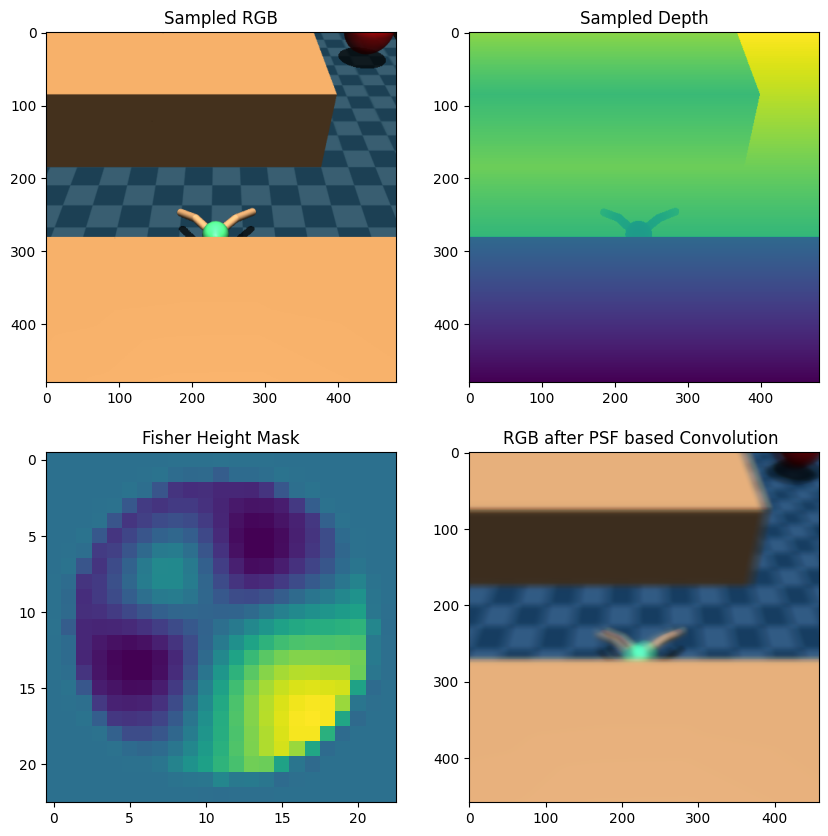

In [63]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rgb)
ax1.set_title("Sampled RGB")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(depth)
ax2.set_title("Sampled Depth")
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(height_mask_fisher)
ax3.set_title("Fisher Height Mask")
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img)
ax4.set_title("RGB after PSF based Convolution ")


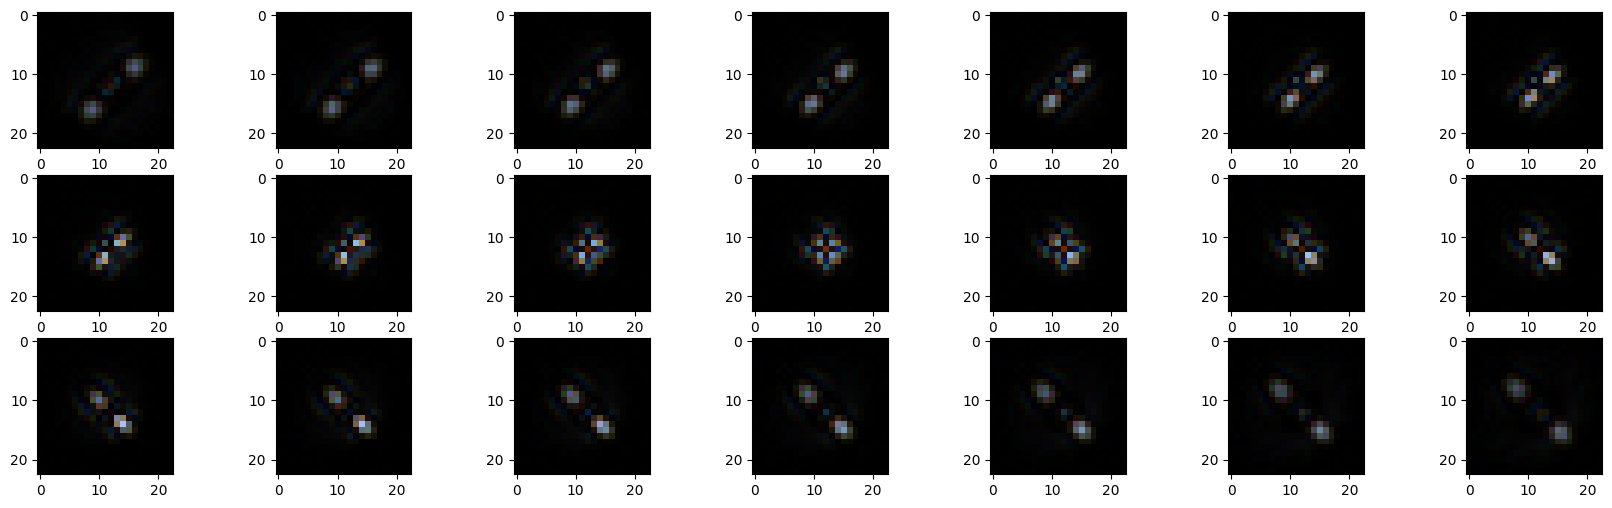

In [61]:
plot_image_grid(normalize(fisher_psfs.numpy()))

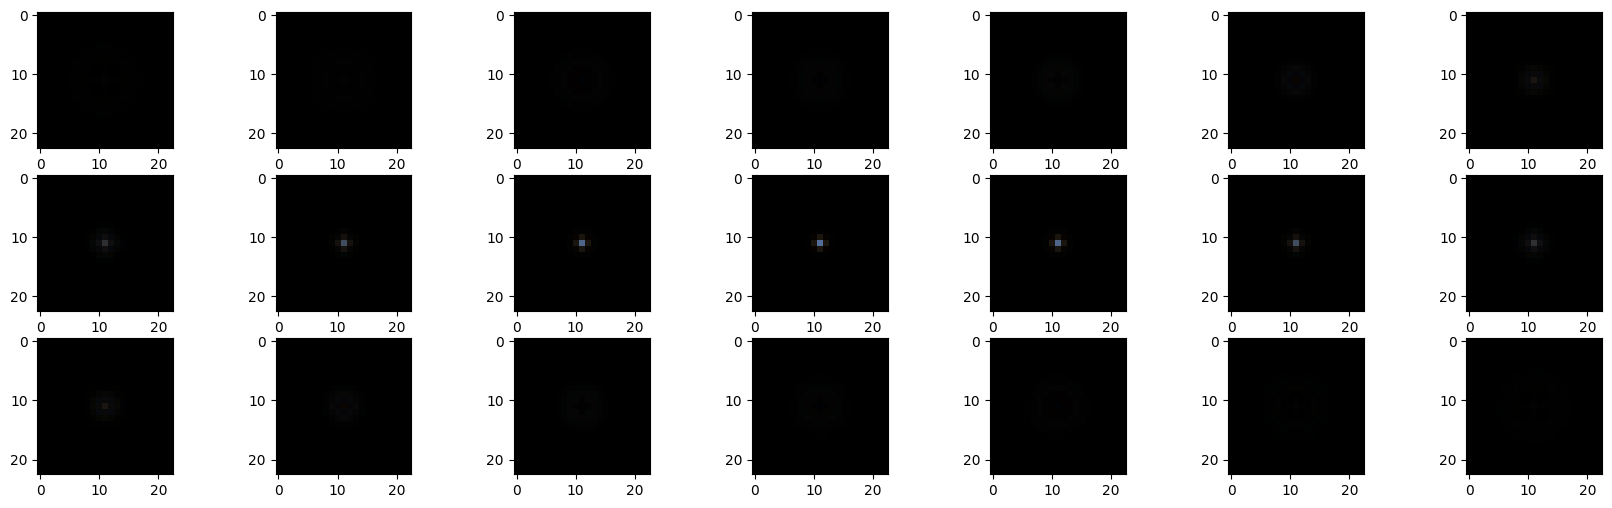

In [62]:
plot_image_grid(psfs.numpy())

In [21]:
depth.shape

(480, 480)

In [43]:
def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)


In [63]:
def compute_disc_depths(mj_depth, disc_depth_range):
    """
    mj_depth must be between (min, max)
    """
    # for each depth value see if it's close to disc_depth_range[n-1] < x < disc_depth_range[n]
    disc_depth = []
    
    # append the first one 
    idx = np.where(mj_depth < disc_depth_range[0])
    disc_depth_i = np.zeros_like(mj_depth ,dtype=np.float32)
    disc_depth_i[idx] = 1
    disc_depth.append(torch.tensor(disc_depth_i).unsqueeze(-1))
    
    for i in range(1, len(disc_depth_range)-1):
        _min = disc_depth_range[i] 
        _max = disc_depth_range[i+1]
        print(i, _min, _max)
        idx = np.where((mj_depth >= _min) & (mj_depth < _max))
        disc_depth_i = np.zeros_like(mj_depth ,dtype=np.float32)
        disc_depth_i[idx] = 1
        disc_depth.append(torch.tensor(disc_depth_i).unsqueeze(-1))

    # append the last one 
    idx = np.where(mj_depth >= disc_depth_range[-1])
    disc_depth_i = np.zeros_like(mj_depth ,dtype=np.float32)
    disc_depth_i[idx] = 1
    disc_depth.append(torch.tensor(disc_depth_i).unsqueeze(-1))

    disc_depth = torch.concat(disc_depth, -1)
    return disc_depth

In [65]:
depth_min = 0.
depth_max = 1.
depth_bins = 20
disc_depth_range = np.linspace(depth_min, depth_max, depth_bins, np.float32) 

depth = np.random.uniform(size=(480,480))
depth = np.zeros((480,480)) + disc_depth_range[0]
depth = np.array(np.load("../3d_debug/depth_array_0.npy"))
print(depth.shape)
disc_depth = compute_disc_depths(depth, disc_depth_range)
disc_depth.shape

(480, 480)
1 0.05263157894736842 0.10526315789473684
2 0.10526315789473684 0.15789473684210525
3 0.15789473684210525 0.21052631578947367
4 0.21052631578947367 0.2631578947368421
5 0.2631578947368421 0.3157894736842105
6 0.3157894736842105 0.3684210526315789
7 0.3684210526315789 0.42105263157894735
8 0.42105263157894735 0.47368421052631576
9 0.47368421052631576 0.5263157894736842
10 0.5263157894736842 0.5789473684210527
11 0.5789473684210527 0.631578947368421
12 0.631578947368421 0.6842105263157894
13 0.6842105263157894 0.7368421052631579
14 0.7368421052631579 0.7894736842105263
15 0.7894736842105263 0.8421052631578947
16 0.8421052631578947 0.894736842105263
17 0.894736842105263 0.9473684210526315
18 0.9473684210526315 1.0


torch.Size([480, 480, 20])

In [71]:
(disc_depth[:,:,-2] == True).all()

tensor(True)

In [72]:
depth.shape

(480, 480)